# Heterogeneous Autoregressive (HAR) Models
## In-Sample Fit
HAR models, or Heterogeneous Autoregressive models, are specialized regression models designed for predicting financial market volatility by accounting for multiple time horizons within the data.
The classic HAR model, introduced by Corsi (2009), captures the dynamics of realized volatility using a simple structure that combines short-term, medium-term, and long-term lagged volatility components. This design is based on the idea that traders and investors operate with diverse time horizons—daily, weekly, and monthly—each contributing differently to overall market volatility.
A standard HAR-RV (Realized Volatility) model looks like this:
$$ RV_{t+1} = \beta_0 + \beta_1 RV_{t} + \beta_2 \left( \frac{1}{5} \sum_{i=0}^{4} RV_{t-i} \right) + \beta_3 \left( \frac{1}{22} \sum_{i=0}^{21} RV_{t-i} \right) + \epsilon_{t+1} $$
Where RV is realized variance for a day. The summation terms over 5 and 22 denote the average realized volatilities over the previous week and month. The beta variables are regression coefficients and eta the the error term.

First, let's load some Python libraries.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
%matplotlib inline
import matplotlib.pyplot as plt

Then we load a time series and do some preprocessing.

In [2]:
df = pd.read_csv('spx.csv', parse_dates=['Date'], dayfirst=True)
df = df.sort_values('Date').set_index('Date')
r = df['S&P500'].pct_change().dropna()
r = np.log1p(r)       # Convert to continuous log returns
r = r * 100           # Scale returns (numbers too close to zero can cause numerical problems)
r = r - r.mean()      # Demean returns
rs = r ** 2           # Squared returns as variance innovations, instantaneous variance

Then we can set up the HAR(1,5,22) regressors

In [3]:
rv = rs # realised variance on day t+1
rv1 = rs.shift(1) # realised variance on day t
rv5 = rs.rolling(window=5).mean().shift(1) # average weeky realized variance
rv22 = rs.rolling(window=22).mean().shift(1) # average monthly realized variance

Combine Y and the X variables into a dataframe har, and get rid of any NA values due to the shifting.

In [18]:
har = pd.concat([rv, rv1, rv5, rv22], axis=1) # add the Y and all X variables
har.columns = ['rv', 'rv1', 'rv5', 'rv22'] # label the columns
har = har.dropna() # bye-bye na values

print(har)

                  rv       rv1       rv5      rv22
Date                                              
1928-02-02  0.296720  0.063510  0.412073  0.538545
1928-02-03  1.788295  0.296720  0.398988  0.538750
1928-02-06  0.069091  1.788295  0.736718  0.617205
1928-02-07  0.006629  0.069091  0.480894  0.575966
1928-02-08  0.068740  0.006629  0.444849  0.559864
...              ...       ...       ...       ...
2025-09-04  0.651381  0.234854  0.265157  0.426885
2025-09-05  0.116359  0.651381  0.386212  0.362388
2025-09-08  0.034700  0.116359  0.392539  0.355805
2025-09-09  0.059710  0.034700  0.310775  0.335017
2025-09-10  0.074968  0.059710  0.219401  0.337241

[24516 rows x 4 columns]


It is useful also to align the original return time series to the HAR model data.

In [16]:
r = r.loc[har.index]

print(r)

Date
1928-02-02    0.544720
1928-02-03   -1.337271
1928-02-06    0.262852
1928-02-07   -0.081421
1928-02-08    0.262183
                ...   
2025-09-04    0.807082
2025-09-05   -0.341114
2025-09-08    0.186280
2025-09-09    0.244357
2025-09-10    0.273802
Name: S&P500, Length: 24516, dtype: float64


The Box-Cox transformation is often used for HAR models. So let us set up a dedicated function

In [19]:
def boxcox_transform(df, lam):
    if lam < 0: # this is unusal: lambda is not really defined for values smaller than one.
                # lam < 0 means that we do not transform, i.e. just return the original data.
        return df    
    elif lam == 0:
        return np.log1p(df)
    else:
        return ((df + 1) ** lam - 1) / lam

Let use parametrize the Box-Cox transformation in out HAR model.

In [8]:
lambda_value = -1 # -1 means no transform
har_boxcox = boxcox_transform(har, lambda_value)

Derive some useful information about our data that we will use later.

In [17]:
start_date = har_boxcox.index.min().strftime('%Y-%m-%d')
end_date = har_boxcox.index.max().strftime('%Y-%m-%d')
nobs = har_boxcox.shape[0]

print([start_date, end_date, nobs])

['1928-02-02', '2025-09-10', 24516]


The net code block creates a scatter matrix plot with correlation and R^2 values.

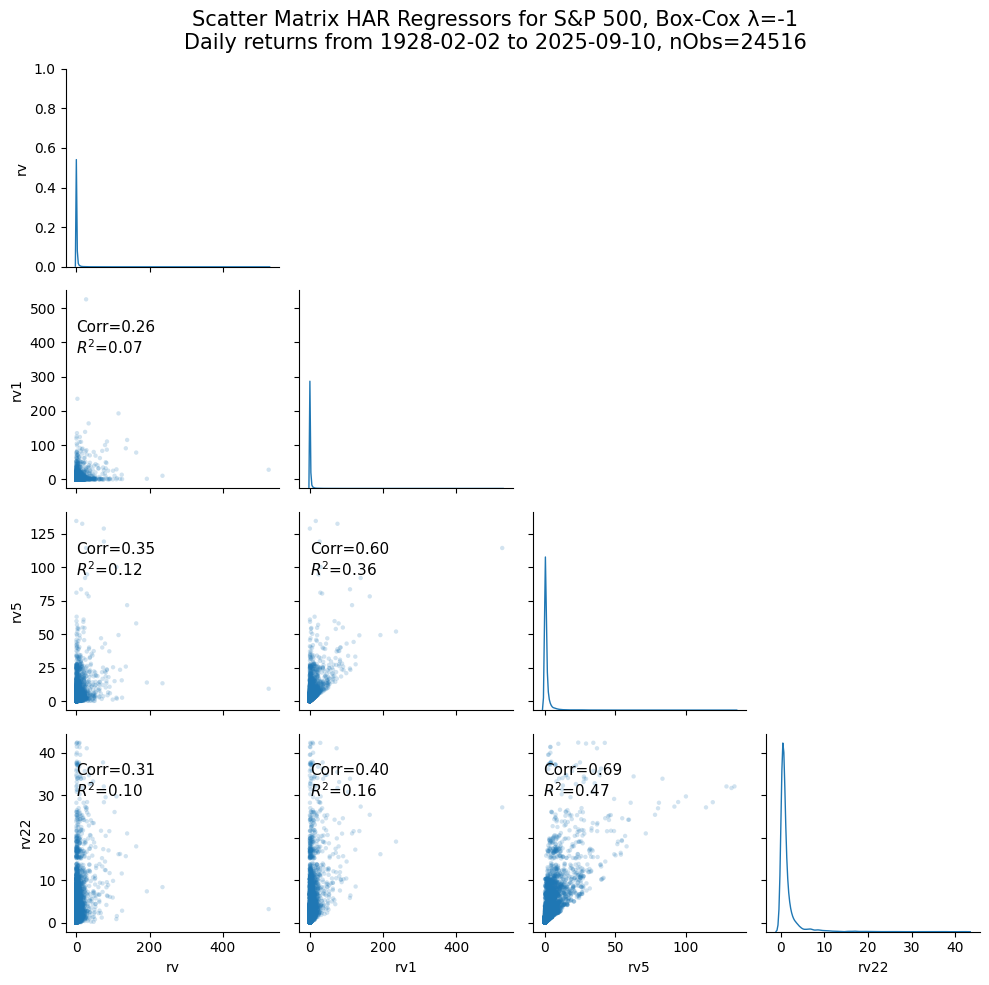

In [10]:
def annotate_corr_r2(x, y, **kwargs):
    mask = (~np.isnan(x)) & (~np.isnan(y))
    if np.sum(mask) > 1:
        corr = np.corrcoef(x[mask], y[mask])[0, 1]
        r2 = corr ** 2
        ax = plt.gca()
        ax.text(0.05, 0.85, f"Corr={corr:.2f}\n$R^2$={r2:.2f}",
                transform=ax.transAxes, fontsize=11, verticalalignment='top')
    plt.scatter(x, y, alpha=0.2, s=10, edgecolors='none')

g = sns.PairGrid(har_boxcox)
g.map_lower(annotate_corr_r2)
g.map_diag(sns.kdeplot, lw=1, warn_singular=False)
for i in range(len(har_boxcox.columns)): # Remove upper triangle axes completely
    for j in range(i+1, len(har_boxcox.columns)):
        ax = g.axes[i, j]
        ax.set_axis_off()
plt.suptitle(
    f'Scatter Matrix HAR Regressors for S&P 500, Box-Cox λ={lambda_value}\n'
    f'Daily returns from {start_date} to {end_date}, nObs={nobs}',
    fontsize=15
)
plt.tight_layout()
plt.show()

To evaluate the in-sample fit of a HAR model, we have to add a n intercept term to our variable har and then get the Y and X variables.

In [11]:
har_boxcox.insert(1, 'const', 1.0)
Y = har_boxcox['rv'].values
X = har_boxcox[['const', 'rv1', 'rv5', 'rv22']].values

The next codeblock performs an in-sample evaluation of rolling windows.

In [12]:
# Rolling coefficients and R^2 that will be collected
params_over_time = []
rolling_r2 = []
indices = []

# Rolling window parameters
step_size = 100
window_size = 1000

# Roll the windows
for i in range(window_size, len(Y), step_size):
    X_win, Y_win = X[i-window_size:i], Y[i-window_size:i]
    model = LinearRegression(fit_intercept=False).fit(X_win, Y_win)
    params_over_time.append(model.coef_)
    indices.append(har_boxcox.index[i])
    y_fit = model.predict(X_win)
    r2 = 1 - np.sum((Y_win - y_fit)**2) / np.sum((Y_win - np.mean(Y_win))**2) if np.sum((Y_win - np.mean(Y_win))**2) > 0 else np.nan
    rolling_r2.append(r2)
    
params_over_time = np.array(params_over_time)

Plot the HAR parameter trajectories, residuals, and rolling R^2

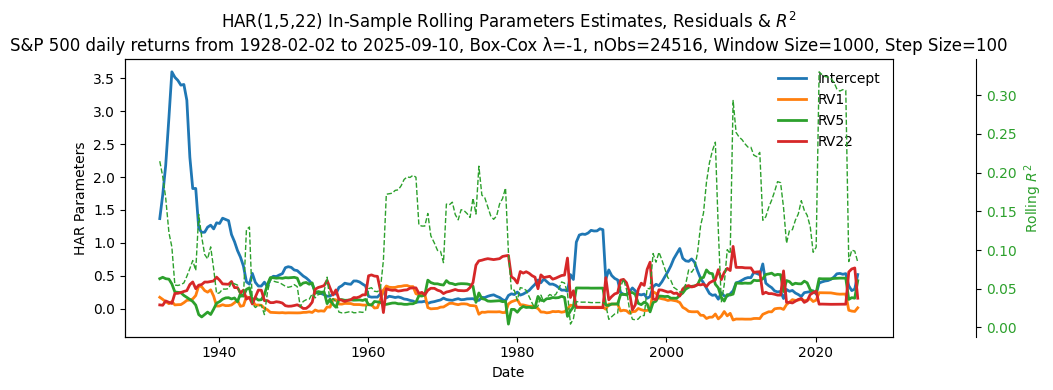

In [13]:
fig, ax1 = plt.subplots(figsize=(10, 4))

param_labels = ['Intercept', 'RV1', 'RV5', 'RV22']
for idx in range(4):
    ax1.plot(indices, params_over_time[:, idx], label=param_labels[idx], lw=2)
ax1.set_xlabel('Date')
ax1.set_ylabel('HAR Parameters')
ax1.legend(loc='best', frameon=False)
ax1.set_title('HAR(1,5,22) In-Sample Rolling Parameters Estimates, Residuals & $R^2$\n'
              + f'S&P 500 daily returns from {start_date} to {end_date}, Box-Cox λ={lambda_value}, nObs={nobs}, Window Size={window_size}, Step Size={step_size}')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(indices, rolling_r2, color='tab:green', lw=1, linestyle='--', label='Rolling $R^2$')
ax3.set_ylabel('Rolling $R^2$', color='tab:green')
ax3.tick_params(axis='y', labelcolor='tab:green')

fig.tight_layout()
plt.show()